In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

In [43]:
# Load updated 10-K, existing 10-Q and 8-K files
df_10k = pd.read_csv("Data/aggregated_sentiment_scores_10K_new.csv")
df_10q = pd.read_csv("Data/aggregated_sentiment_scores_10Q.csv")
df_8k  = pd.read_csv("Data/aggregated_sentiment_scores_8K.csv")

In [44]:
# Parse dates and define week start
df_10k['Filing Date'] = pd.to_datetime(df_10k['Filing Date'])
df_10q['Filing Date'] = pd.to_datetime(df_10q['Filing Date'])
df_8k['Filing Date']  = pd.to_datetime(df_8k['Filing Date'])

In [45]:
for df in [df_10k, df_10q, df_8k]:
    df['Week'] = pd.to_datetime(df['Filing Date'].dt.to_period('W').apply(lambda r: r.end_time).dt.date)

In [36]:
# Count filings per week
weekly_10k_counts = df_10k.groupby('Week').size().rename('num_10k_filings')
weekly_10q_counts = df_10q.groupby('Week').size().rename('num_10q_filings')
weekly_8k_counts = df_8k.groupby('Week').size().rename('num_8k_filings')

In [14]:
# Merge into one table
weekly_filing_counts = pd.concat([weekly_10k_counts, weekly_10q_counts, weekly_8k_counts], axis=1).fillna(0).reset_index()

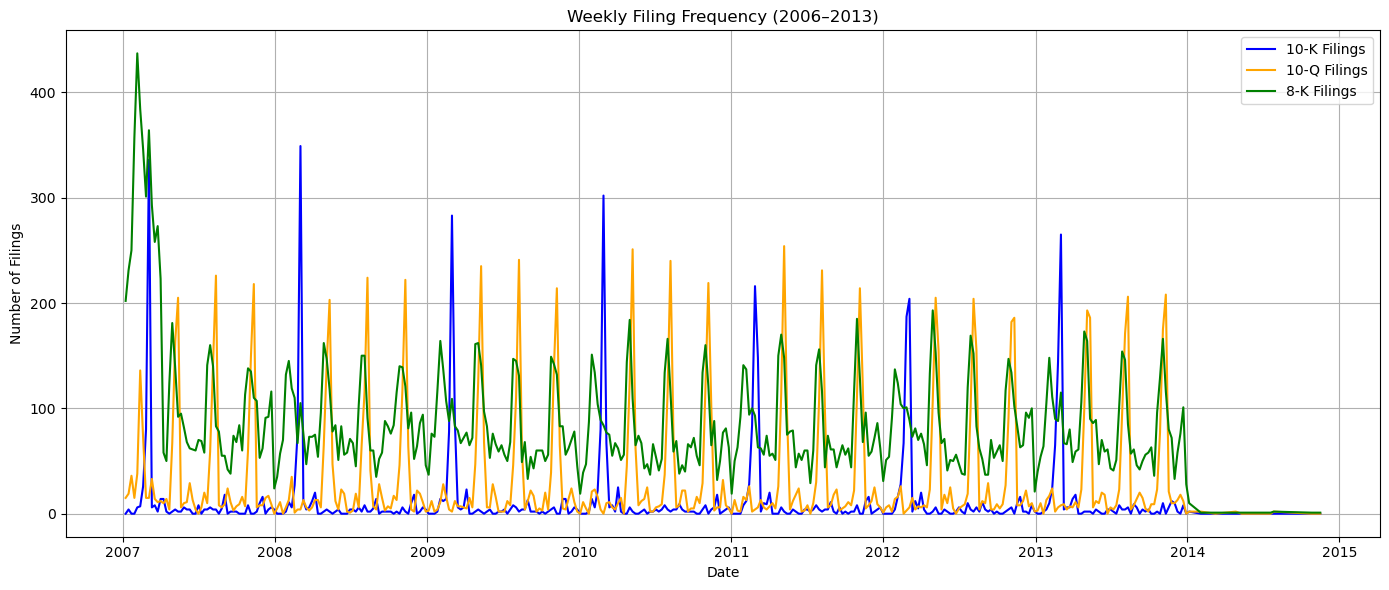

In [16]:
# Section 3.1: Filing Frequency and Coverage
# Already computed weekly_filing_counts

# Plot filing frequency over time
plt.figure(figsize=(14, 6))
plt.plot(weekly_filing_counts['Week'], weekly_filing_counts['num_10k_filings'], label='10-K Filings', color='blue')
plt.plot(weekly_filing_counts['Week'], weekly_filing_counts['num_10q_filings'], label='10-Q Filings', color='orange')
plt.plot(weekly_filing_counts['Week'], weekly_filing_counts['num_8k_filings'], label='8-K Filings', color='green')
plt.title('Weekly Filing Frequency (2006–2013)')
plt.xlabel('Date')
plt.ylabel('Number of Filings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Data/10_day_run/Filings_EDA_weekly_count.png", dpi=300, bbox_inches="tight")
plt.show()

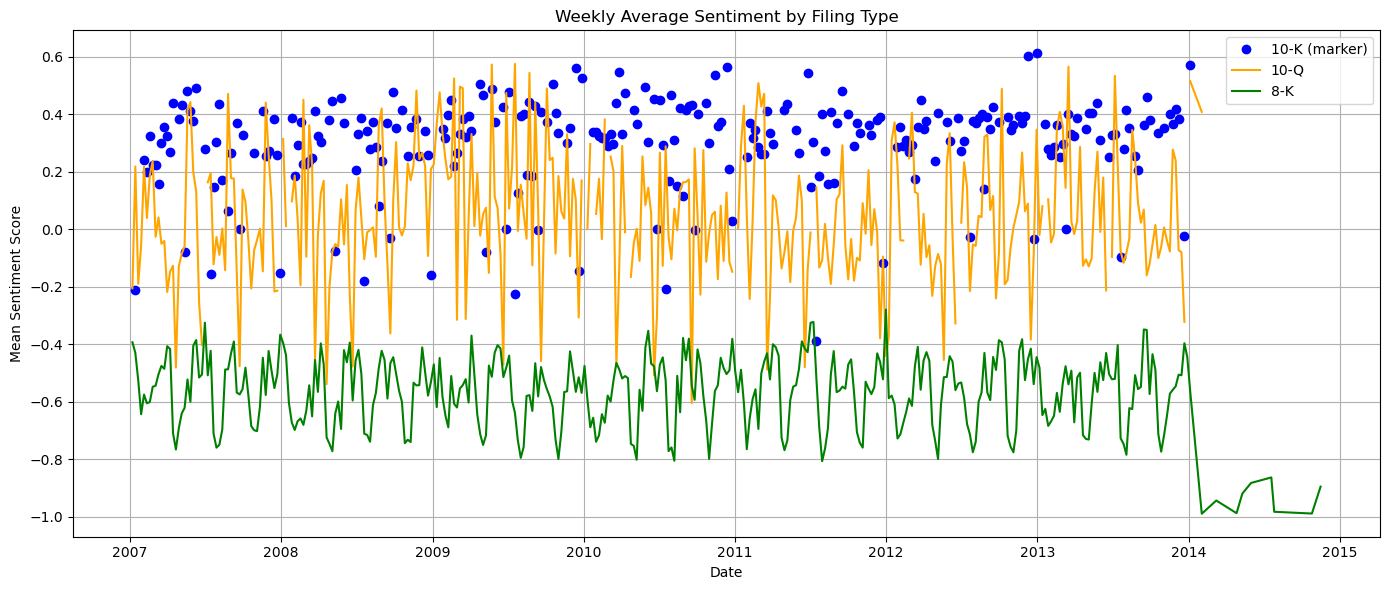

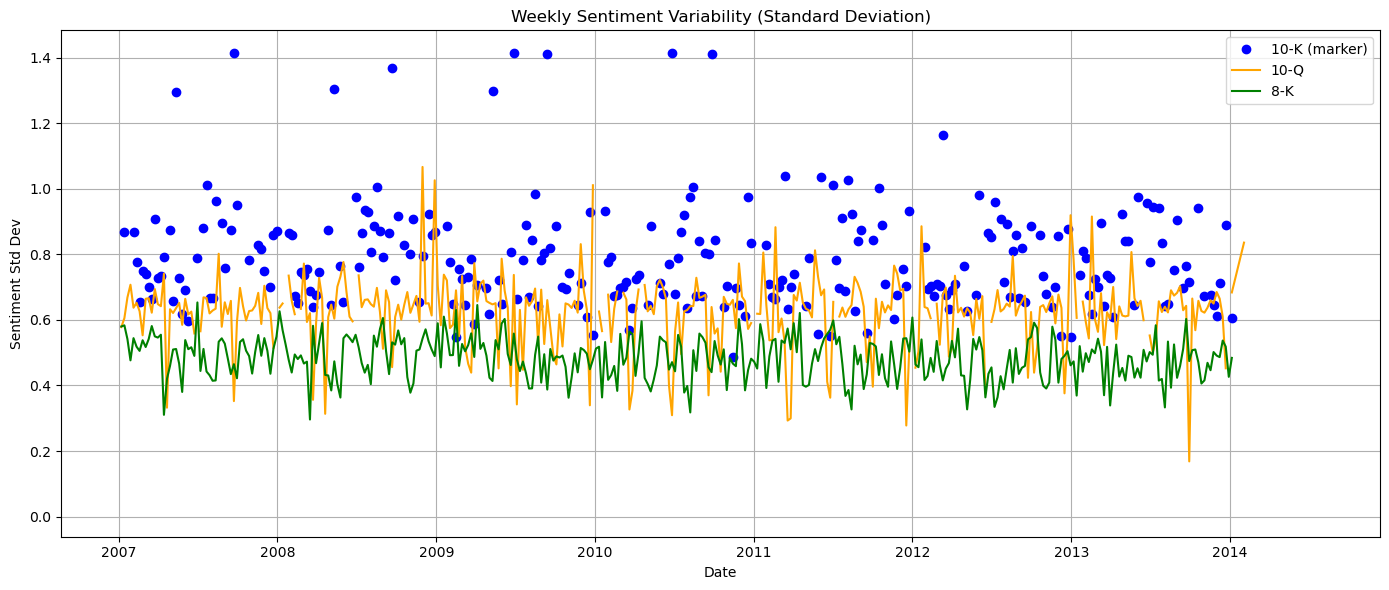

In [17]:
# Section 3.3: Weekly Sentiment Trends and Variability

# Compute weekly mean and std sentiment for each filing type
weekly_sentiment_10k = df_10k.groupby('Week')['Sentiment Score'].agg(['mean', 'std']).rename(columns={'mean': 'mean_10k_sentiment', 'std': 'std_10k_sentiment'})
weekly_sentiment_10q = df_10q.groupby('Week')['Sentiment Score'].agg(['mean', 'std']).rename(columns={'mean': 'mean_10q_sentiment', 'std': 'std_10q_sentiment'})
weekly_sentiment_8k = df_8k.groupby('Week')['Sentiment Score'].agg(['mean', 'std']).rename(columns={'mean': 'mean_8k_sentiment', 'std': 'std_8k_sentiment'})

# Merge all into one DataFrame for plotting
weekly_sentiment_all = pd.concat([weekly_sentiment_10k, weekly_sentiment_10q, weekly_sentiment_8k], axis=1).reset_index()

# Plot weekly mean sentiment trends
plt.figure(figsize=(14, 6))
plt.plot(weekly_sentiment_all['Week'], weekly_sentiment_all['mean_10k_sentiment'], 'o', label='10-K (marker)', color='blue')
plt.plot(weekly_sentiment_all['Week'], weekly_sentiment_all['mean_10q_sentiment'], label='10-Q', color='orange')
plt.plot(weekly_sentiment_all['Week'], weekly_sentiment_all['mean_8k_sentiment'], label='8-K', color='green')
plt.title('Weekly Average Sentiment by Filing Type')
plt.xlabel('Date')
plt.ylabel('Mean Sentiment Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot standard deviation of sentiment to show variability
plt.figure(figsize=(14, 6))
plt.plot(weekly_sentiment_all['Week'], weekly_sentiment_all['std_10k_sentiment'], 'o', label='10-K (marker)', color='blue')
plt.plot(weekly_sentiment_all['Week'], weekly_sentiment_all['std_10q_sentiment'], label='10-Q', color='orange')
plt.plot(weekly_sentiment_all['Week'], weekly_sentiment_all['std_8k_sentiment'], label='8-K', color='green')
plt.title('Weekly Sentiment Variability (Standard Deviation)')
plt.xlabel('Date')
plt.ylabel('Sentiment Std Dev')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
def week_fill(df):
    # make Week a DatetimeIndex and reindex over the full span
    df['Week'] = pd.to_datetime(df['Week'])
    df = df.set_index('Week')
    
    full_idx = pd.date_range(
        start=df.index.min(),
        end  =df.index.max(),
        freq ='W-SUN'                                                       # adjust weekday if needed
    )
    
    # 5) Reindex, ffill, reset
    df = (
        df
        .reindex(full_idx)    # will now insert missing weeks as NaN rows
        .ffill()              # carry last real values forward
        .reset_index()
        .rename(columns={'index':'Week'})
    )

    return df

In [48]:
df_10k.head()

,CIK,Type,Filing Date,Section,Sentiment Score,Sentiment Label,Week
0,1000697,10-K,2007-03-01,item_1A,0.999054,positive,2007-03-04
1,1000697,10-K,2007-03-01,item_7,-0.324787,negative,2007-03-04
2,1000697,10-K,2008-02-29,item_1A,0.985981,positive,2008-03-02
3,1000697,10-K,2008-02-29,item_7,-0.298994,negative,2008-03-02
4,1000697,10-K,2009-02-27,item_1A,0.992333,positive,2009-03-01


In [49]:
# 10-K EDA: only Section 'item_7'
sec7 = df_10k[df_10k['Section'] == 'item_7']
weekly_10k = sec7.groupby('Week').agg(
    mean_sent=('Sentiment Score','mean'),
    count=('Sentiment Score','count')
).reset_index()

weekly_10k = week_fill(weekly_10k)

In [50]:
# 10-Q EDA: two sections
sections = {
    'part_1_item_2': 'MD&A',
    'part_2_item_1A': 'Risk Factors'
}
weekly_10q = {}
for code, name in sections.items():
    subset = df_10q[df_10q['Section'] == code]
    weekly_10q[name] = subset.groupby('Week').agg(
        mean_sent=('Sentiment Score','mean'),
        count=('Sentiment Score','count')
    ).reset_index()

    weekly_10q[name] = week_fill(weekly_10q[name])

In [51]:
# 8-K EDA: all sections combined
weekly_8k = df_8k.groupby('Week').agg(
    mean_sent=('Sentiment Score','mean'),
    count=('Sentiment Score','count')
).reset_index()
weekly_8k = week_fill(weekly_8k)

## 10-K - Plots

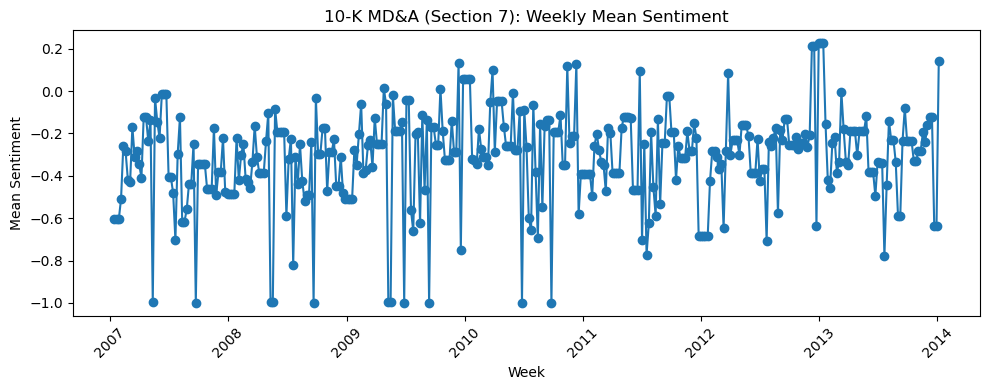

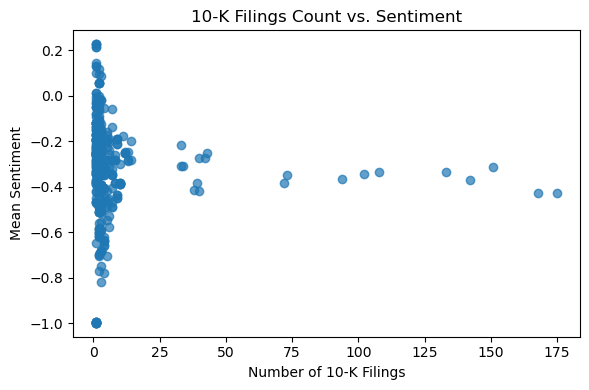

In [53]:
# Plotting
plt.figure(figsize=(10,4))
plt.plot(weekly_10k['Week'], weekly_10k['mean_sent'], marker='o')
plt.title("10-K MD&A (Section 7): Weekly Mean Sentiment")
plt.xlabel("Week"); plt.ylabel("Mean Sentiment")
plt.xticks(rotation=45); plt.tight_layout(); 
plt.savefig("Data/10_day_run/Filings_EDA_10k_weekly_mean.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(weekly_10k['count'], weekly_10k['mean_sent'], alpha=0.7)
plt.title("10-K Filings Count vs. Sentiment"); plt.xlabel("Number of 10-K Filings"); plt.ylabel("Mean Sentiment")
plt.tight_layout()
plt.show()

## 10-Q plots

In [56]:
section_1a_scores = weekly_10q['MD&A']['mean_sent'].dropna()
section_7_scores = weekly_10q['Risk Factors']['mean_sent'].dropna()

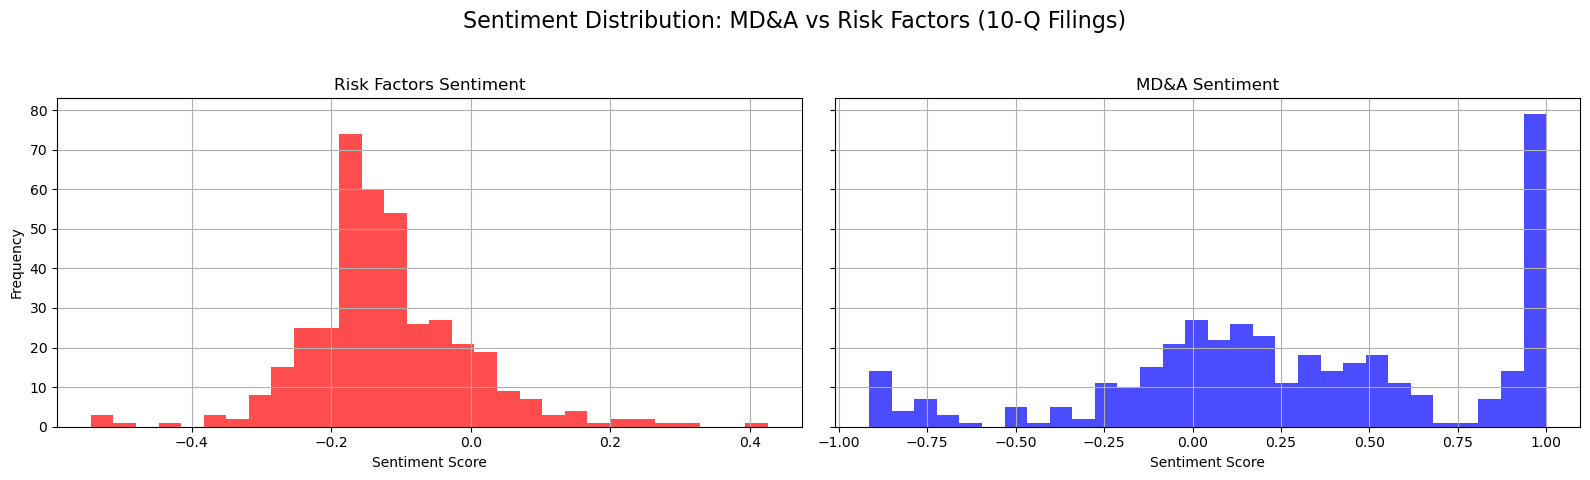

In [60]:
# Plot histograms
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

axs[0].hist(section_1a_scores, bins=30, color='red', alpha=0.7)
axs[0].set_title("Risk Factors Sentiment")
axs[0].set_xlabel("Sentiment Score")
axs[0].set_ylabel("Frequency")
axs[0].grid(True)

axs[1].hist(section_7_scores, bins=30, color='blue', alpha=0.7)
axs[1].set_title("MD&A Sentiment")
axs[1].set_xlabel("Sentiment Score")
axs[1].grid(True)

plt.suptitle("Sentiment Distribution: MD&A vs Risk Factors (10-Q Filings)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Data/10_day_run/Filings_EDA_10q_sections.png", dpi=300, bbox_inches="tight")
plt.show()

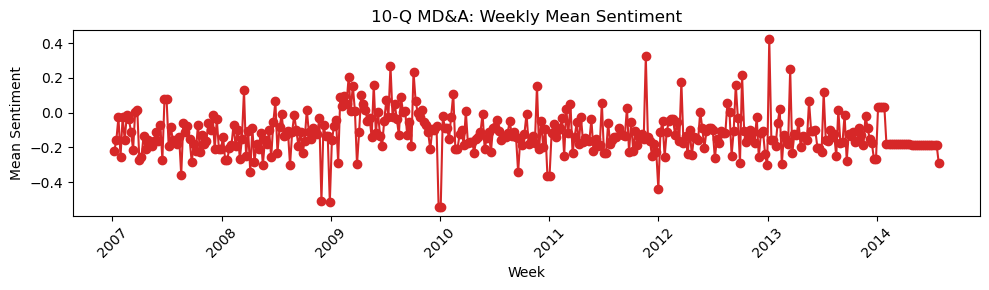

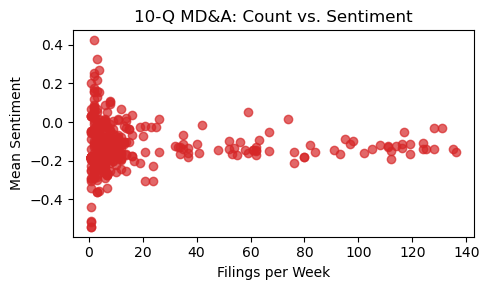

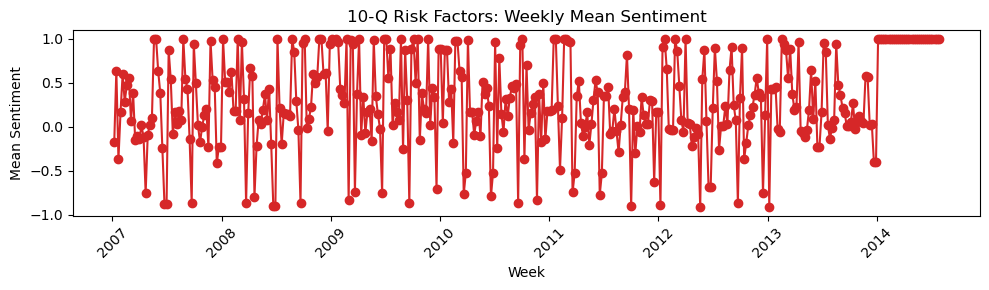

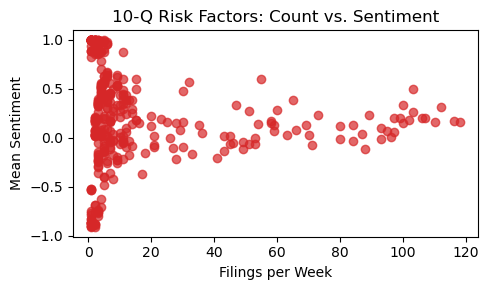

In [54]:
for name, weekly in weekly_10q.items():
    plt.figure(figsize=(10,3))
    plt.plot(weekly['Week'], weekly['mean_sent'], marker='o', color='C3')
    plt.title(f"10-Q {name}: Weekly Mean Sentiment")
    plt.xlabel("Week"); plt.ylabel("Mean Sentiment")
    plt.xticks(rotation=45); plt.tight_layout(); 
    plt.savefig(f"Data/10_day_run/Filings_EDA_10q_{name}_weekly_mean.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    plt.figure(figsize=(5,3))
    plt.scatter(weekly['count'], weekly['mean_sent'], alpha=0.7, color='C3')
    plt.title(f"10-Q {name}: Count vs. Sentiment")
    plt.xlabel("Filings per Week"); plt.ylabel("Mean Sentiment")
    plt.tight_layout(); plt.show()


## Observations:

Weekly MD&A Sentiment (10-Q): A fairly tight band around –0.2, with occasional spikes/dips around earnings‐release quarters.

MD&A Count vs. Sentiment: Shows that low‐count weeks have more dispersed scores (just like news), while high‐count weeks cluster.

Weekly Risk Factors Sentiment: Much more positive (leaning close to +1). That’s expected—risk sections often frame forward‐looking opportunities as “positives” in our labeling scheme.

Risk Factors Count vs. Sentiment: Highlights that weeks with only a few risk‐section filings drive that +1 mass; when more firms report, sentiment drifts toward neutral.

## 8-K Plots

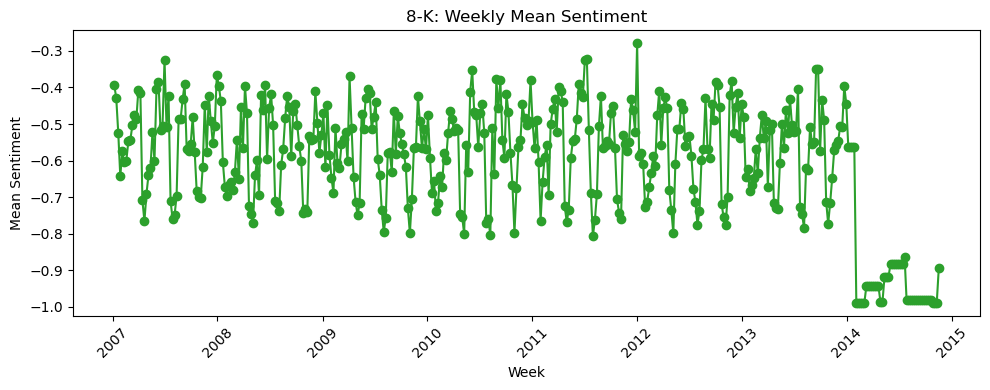

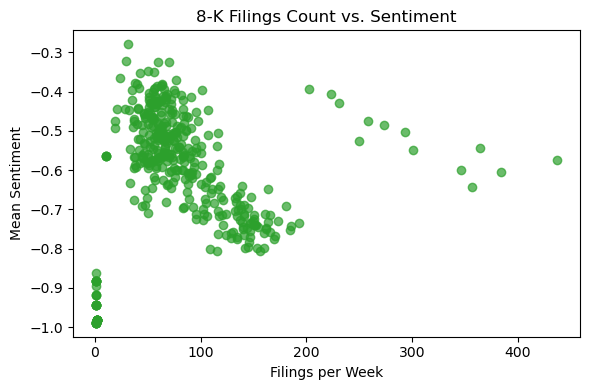

In [55]:
plt.figure(figsize=(10,4))
plt.plot(weekly_8k['Week'], weekly_8k['mean_sent'], marker='o', color='C2')
plt.title("8-K: Weekly Mean Sentiment"); plt.xlabel("Week"); plt.ylabel("Mean Sentiment")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.scatter(weekly_8k['count'], weekly_8k['mean_sent'], alpha=0.7, color='C2')
plt.title("8-K Filings Count vs. Sentiment"); plt.xlabel("Filings per Week"); plt.ylabel("Mean Sentiment")
plt.tight_layout(); 
plt.savefig("Data/10_day_run/Filings_EDA_8k_weekly_mean.png", dpi=300, bbox_inches="tight")
plt.show()

## Next questions & ideas:

Separate or combine? These two 10-Q sections behave very differently, so it’s best to **keep them as distinct features** (e.g. mean_10Q_MD&A, mean_10Q_Risk)—that gives your model more nuance about tone and section.

Smoothing/flags: Just like with news, you might want to flag low‐coverage weeks for both 10-Q sections, or roll‐average the sentiment there too.

10-K & 8-K: Let me know if you want similar “low‐coverage smoothing” on those, or additional breakdown (e.g. by 8-K item code).

Feature engineering: You could compute the difference between MD&A and Risk tones, or their ratio, as an indicator of “overall optimism vs. caution” each week.

## Thinking

1. **Forward-fill for 10-Q and 10-K**
   Because 10-Q (quarterly) and 10-K (annual) filings arrive at irregular, sparse points in your weekly series, carrying their last observed sentiment forward until the next release is a sensible way to create a continuous weekly feature. It effectively assumes “nothing changed” in manager tone between filings—just as you’d treat a published quarterly GDP figure or unemployment rate. This lets your model see a well‐defined value for every week, without inventing spurious zeros or dropping large chunks of time.

2. **Should you smooth 10-Q or 8-K?**

   * **10-Q (MD\&A and Risk Factors)**
     These sections tend to move more gradually from quarter to quarter. If you see a single week with just one or two filings, that tiny sample can produce a wild spike or drop (just as with news). You can either:

     * **Flag low-coverage weeks** (\<N filings) and let the model learn when the sentiment is less reliable, or
     * **Apply a short rolling window** (e.g. 2–3 weeks) to “soften” abrupt jumps caused by thin data.
       Smoothing can reduce random noise, but too much will blur genuine shifts in manager outlook from one quarter to the next—so keep your window very tight.

   * **8-K (Event-driven)**
     These filings are **by design** bursty: a big acquisition, a bankruptcy, a director change, etc., all get filed via 8-K. Smoothing them risks muting exactly the signal you want—those one-off events. Better to leave 8-K sentiment **unsmoothed**, but again **flag** weeks with extremely low counts (e.g. zero or one 8-K) so your model knows when that feature is less informative.

3. **“Overall optimism vs. caution”**
   You have two distinct sentiment streams from 10-Q:

   * **MD\&A tone** (management’s narrative, forward-looking positives or negatives)
   * **Risk Factors tone** (enumeration of threats, which in many labeling schemes can skew positive when firms list mitigants as “opportunities”)

   **Optimism‐vs‐Caution = MD\&A sentiment – Risk Factors sentiment**

   * A **large positive** difference means MD\&A is upbeat relative to how many and how sharply firms are describing risks → managers are talking up opportunities, and downplaying threats.
   * A **negative** difference means the “risk section” is darker than the narrative elsewhere, implying managers are emphasizing what could go wrong more than what’s going right.
   * Values **near zero** suggest a balanced message.

   Feeding this spread into your model gives it a compact measure of “net tone” each week—whether management is painting a rosier picture (optimism) or a more cautious one. It often outperforms either raw MD\&A or raw Risk Factors sentiment alone, because it captures the **tension** between growth narratives and risk disclosures.


### Smoothing 10-Q and adding Optimism‐vs‐Caution

In [35]:
# Separate MD&A and Risk Factors sections
mda = df_10q[df_10q['Section'] == 'part_1_item_2']
risk = df_10q[df_10q['Section'] == 'part_2_item_1A']

In [36]:
# Compute weekly mean sentiment
weekly_mda = mda.groupby('Week')['Sentiment Score'].mean().rename('mda_sent')
weekly_risk = risk.groupby('Week')['Sentiment Score'].mean().rename('risk_sent')

In [39]:
# Combine into single DataFrame
weekly = pd.concat([weekly_mda, weekly_risk], axis=1).sort_index().reset_index()

In [40]:
weekly.head()

,Week,mda_sent,risk_sent
0,2007-01-07,-0.221861,-0.171638
1,2007-01-14,-0.157317,0.637004
2,2007-01-21,-0.026831,-0.370284
3,2007-01-28,-0.252746,0.166577
4,2007-02-04,-0.026999,0.595046


In [41]:
# Forward-fill missing weeks
weekly = week_fill(weekly)

In [42]:
# Smooth each series with a 2-week rolling average
weekly['mda_smoothed'] = weekly['mda_sent'].rolling(2, min_periods=1).mean()
weekly['risk_smoothed'] = weekly['risk_sent'].rolling(2, min_periods=1).mean()

In [43]:
# Compute optimism vs. caution
weekly['opt_vs_caut'] = weekly['mda_smoothed'] - weekly['risk_smoothed']

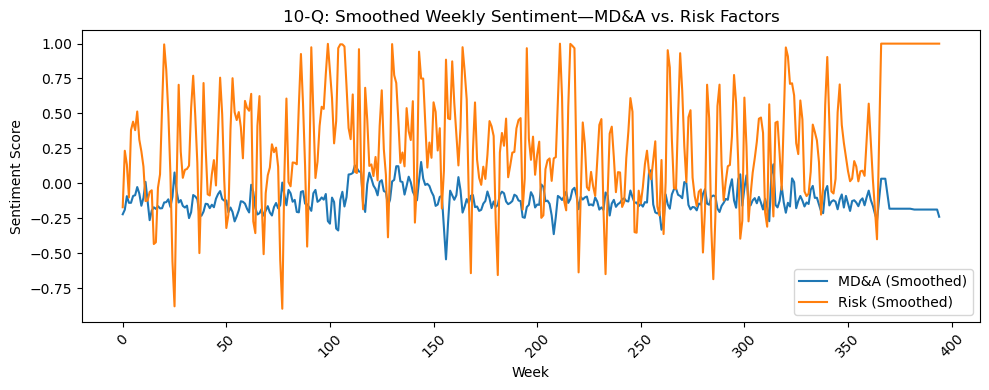

In [44]:
# Plot 1: Smoothed MD&A vs. Risk Factors sentiment
plt.figure(figsize=(10, 4))
plt.plot(weekly.index, weekly['mda_smoothed'], label='MD&A (Smoothed)')
plt.plot(weekly.index, weekly['risk_smoothed'], label='Risk (Smoothed)')
plt.title('10-Q: Smoothed Weekly Sentiment—MD&A vs. Risk Factors')
plt.xlabel('Week')
plt.ylabel('Sentiment Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

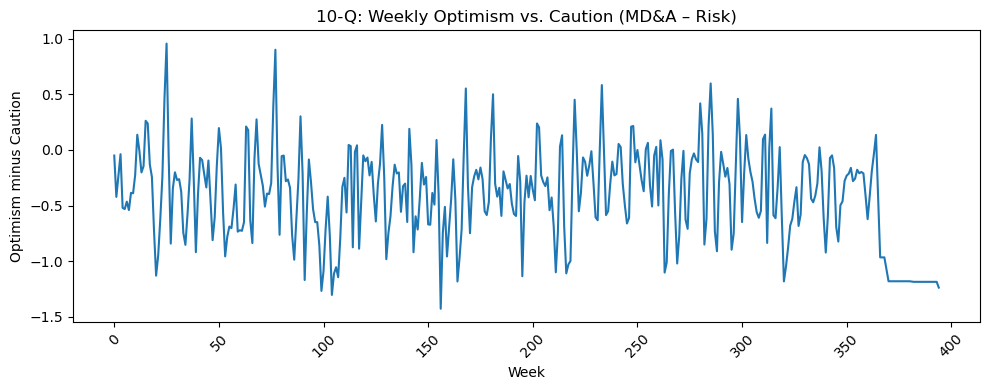

In [45]:
# Plot 2: Optimism vs. Caution over time
plt.figure(figsize=(10, 4))
plt.plot(weekly.index, weekly['opt_vs_caut'])
plt.title('10-Q: Weekly Optimism vs. Caution (MD&A – Risk)')
plt.xlabel('Week')
plt.ylabel('Optimism minus Caution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Saving

In [6]:
# 10-K: keep only MD&A section (item 7), group, forward-fill
df_10k_mdna = df_10k[df_10k['Section'].str.contains('item_7', case=False)]
weekly_10k = df_10k_mdna.groupby('Week')['Sentiment Score']\
    .agg(sent_10k_mean='mean', count_10k='count')\
    .sort_index()\
    .ffill()\
    .reset_index()

In [7]:
# 10-Q: separate sections, group, forward-fill and smooth
mda = df_10q[df_10q['Section'] == 'part_1_item_2']
risk = df_10q[df_10q['Section'] == 'part_2_item_1A']
weekly_mda = mda.groupby('Week')['Sentiment Score'].mean().rename('mda_sent')
weekly_risk = risk.groupby('Week')['Sentiment Score'].mean().rename('risk_sent')

# 2. Compute weekly count of 10‑Q rows
weekly_count = df_10q.groupby('Week').size().rename('count_10q')

weekly_10q = pd.concat([weekly_mda, weekly_risk, weekly_count], axis=1).sort_index().ffill()
weekly_10q['mda_smoothed'] = weekly_10q['mda_sent'].rolling(2, min_periods=1).mean()
weekly_10q['risk_smoothed'] = weekly_10q['risk_sent'].rolling(2, min_periods=1).mean()
weekly_10q['opt_vs_caut']   = weekly_10q['mda_smoothed'] - weekly_10q['risk_smoothed']
weekly_10q = weekly_10q.reset_index()

In [8]:
# 8-K: all sections, group, forward-fill
weekly_8k = df_8k.groupby('Week')['Sentiment Score']\
    .agg(sent_8k_mean='mean', count_8k='count')\
    .sort_index()\
    .ffill()\
    .reset_index()

In [10]:
# Save outputs
weekly_10k.to_csv("Data/weekly_10k.csv", index=False)
weekly_10q.to_csv("Data/weekly_10q.csv", index=False)
weekly_8k.to_csv("Data/weekly_8k.csv", index=False)